In [64]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import shap
import matplotlib.pyplot as plt

df = pd.read_csv('data/df.csv')
utterance_df = pd.read_csv('data/utterance_features.csv')
smile_df = pd.read_csv('data/smile_features.csv')

utterance_columns = utterance_df.columns[1:]
smile_columns = smile_df.columns[1:]

train_df = df[df["Split"] == "train"]
dev_df = df[df["Split"] == "dev"]
test_df = df[df["Split"] == "test"]

target_column = "PHQ8_Binary"
drop_cols = ["PHQ8_Score", "Split", "Participant_ID", target_column]

feature_cols = [col for col in df.columns if col not in drop_cols]

X_train = train_df[feature_cols]
y_train = train_df[target_column]

X_dev = dev_df[feature_cols]
y_dev = dev_df[target_column]

X_test = test_df[feature_cols]
y_test = test_df[target_column]

model = xgb.XGBClassifier(random_state=42, eval_metric='logloss', early_stopping_rounds=10)
model.fit(
    X_train, y_train,
    eval_set=[(X_dev, y_dev)],
    verbose=False
)

y_pred = model.predict(X_test)

print("Classification Report (Test Data):")
print(classification_report(y_test, y_pred))

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.73      0.91      0.81        33
           1       0.50      0.21      0.30        14

    accuracy                           0.70        47
   macro avg       0.62      0.56      0.56        47
weighted avg       0.66      0.70      0.66        47



<Figure size 1200x2000 with 0 Axes>

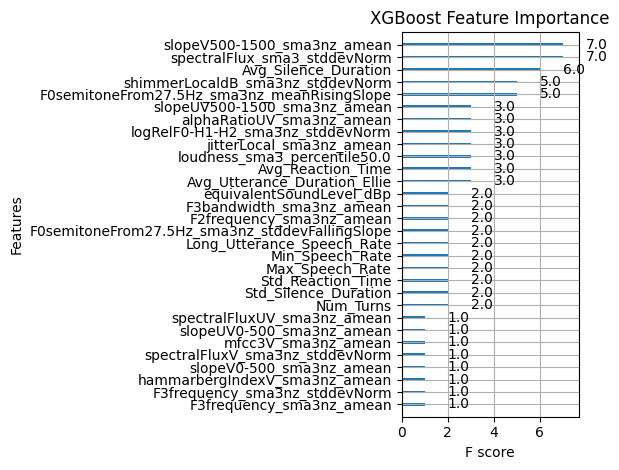

In [66]:
# XGBoost Feature importance

from xgboost import plot_importance

plt.figure(figsize=(12, 20))
plot_importance(model, max_num_features=30, importance_type='weight')
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()

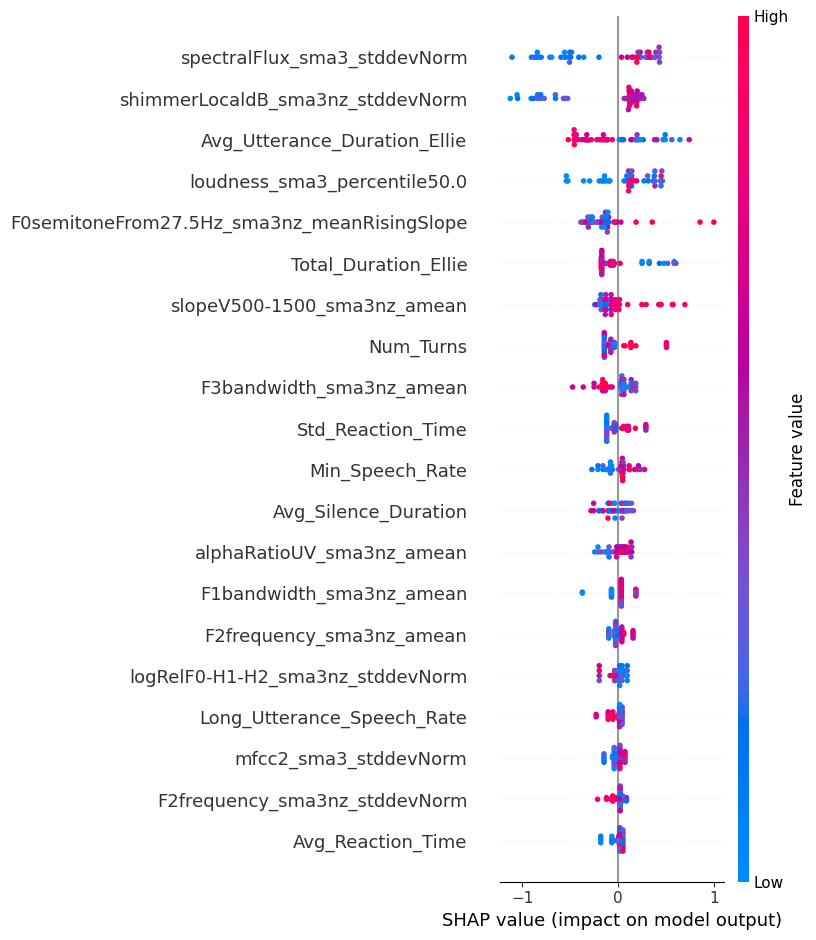

In [46]:
# SHAP (all features)

explainer = shap.Explainer(model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, features=X_test, feature_names=feature_cols)

🔵 SHAP summary for Male (Gender=1)


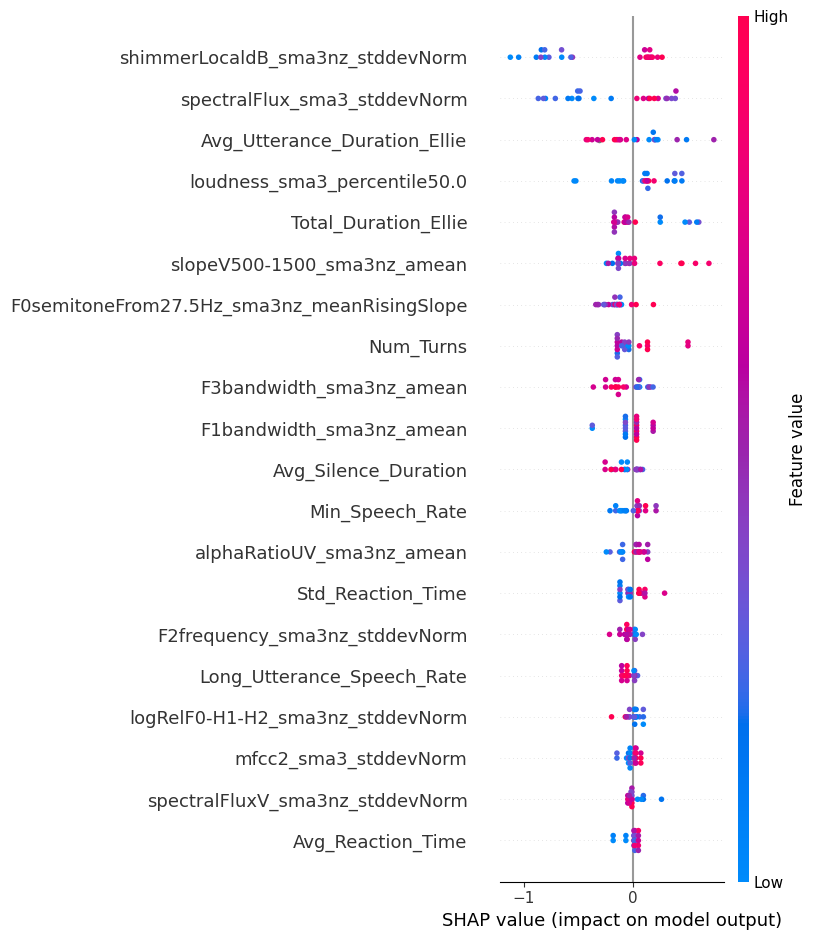

🔴 SHAP summary for Female (Gender=0)


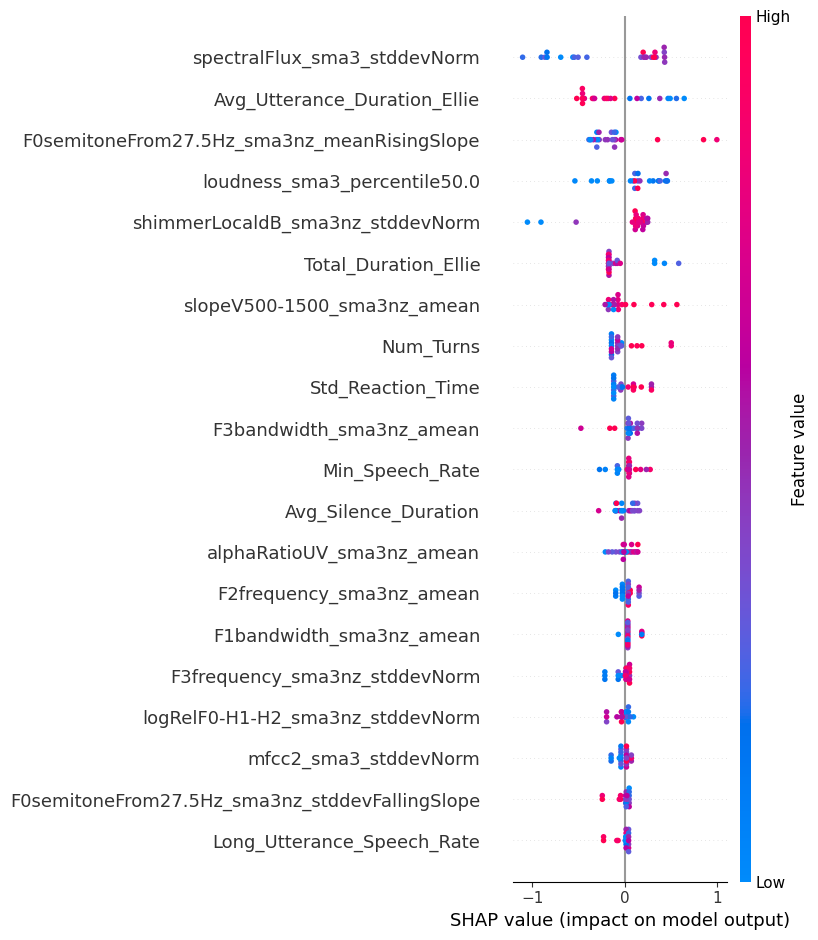

In [47]:
# Male vs. Female

X_male = X_test[test_df["Gender"].values == 1]
X_female = X_test[test_df["Gender"].values == 0]
shap_male = shap_values[test_df["Gender"].values == 1]
shap_female = shap_values[test_df["Gender"].values == 0]

print("🔵 SHAP summary for Male (Gender=1)")
shap.summary_plot(shap_male, features=X_male, feature_names=feature_cols)

print("🔴 SHAP summary for Female (Gender=0)")
shap.summary_plot(shap_female, features=X_female, feature_names=feature_cols)

In [48]:
bins = [float('-inf'), 10, 15, 20, float('inf')]
labels = ['<=10', '10~15', '15~20', '20+']

df['PHQ8_group'] = pd.cut(df['PHQ8_Score'], bins=bins, labels=labels, right=False)

group_counts = df['PHQ8_group'].value_counts().sort_index()

print(group_counts)

PHQ8_group
<=10     132
10~15     30
15~20     20
20+        7
Name: count, dtype: int64


🔵 SHAP summary for High Depression (score>=15)


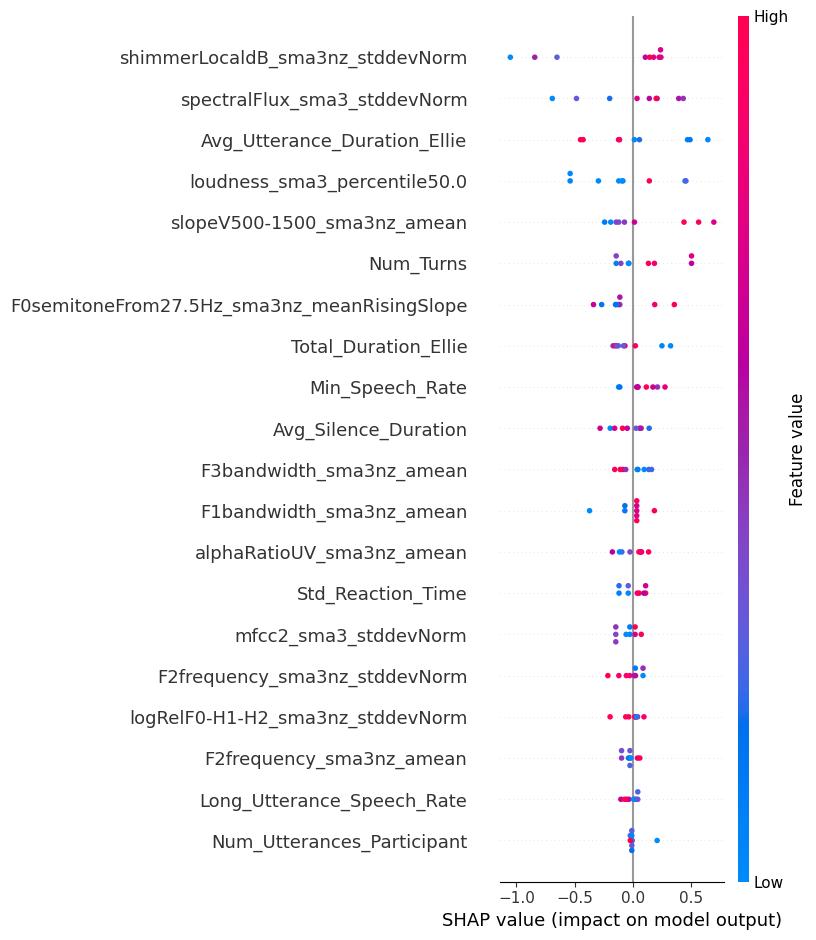

🔴 SHAP summary for Low Depression (10 <= score < 15)


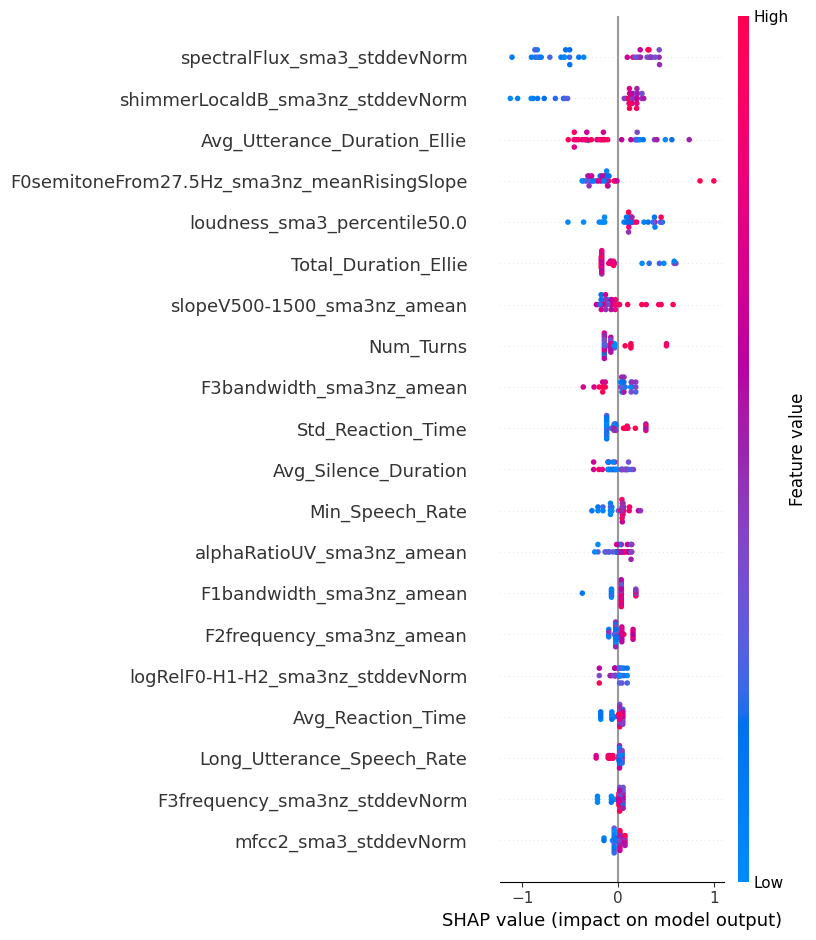

In [49]:
# High Depression vs. Low Depression

X_high = X_test[test_df["PHQ8_Score"].values >= 15]
X_low = X_test[(test_df["PHQ8_Score"].values <= 10)&(test_df["PHQ8_Score"].values< 15)]
shap_high = shap_values[test_df["PHQ8_Score"].values >= 15]
shap_low = shap_values[(test_df["PHQ8_Score"].values <= 10)&(test_df["PHQ8_Score"].values< 15)]

print("🔵 SHAP summary for High Depression (score>=15)")
shap.summary_plot(shap_high, features=X_high, feature_names=feature_cols)

print("🔴 SHAP summary for Low Depression (10 <= score < 15)")
shap.summary_plot(shap_low, features=X_low, feature_names=feature_cols)

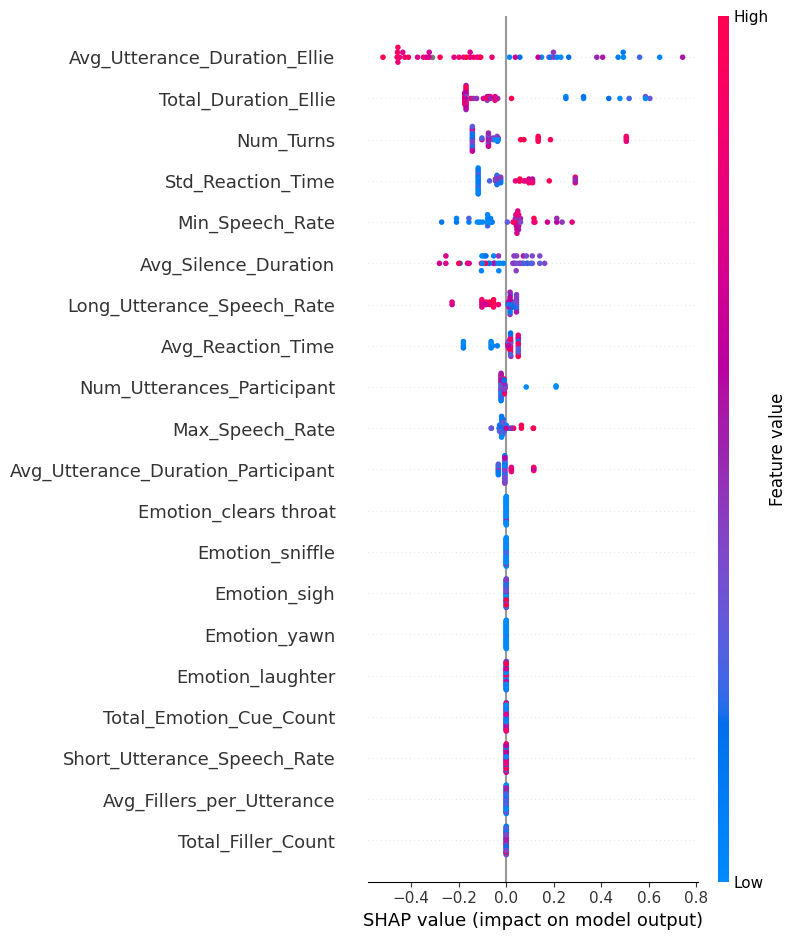

In [50]:
# utterance feature만 SHAP 계산

shap.summary_plot(
    shap_values.values[:, [feature_cols.index(f) for f in utterance_columns]],
    features=X_test[utterance_columns],
    feature_names=utterance_columns
)

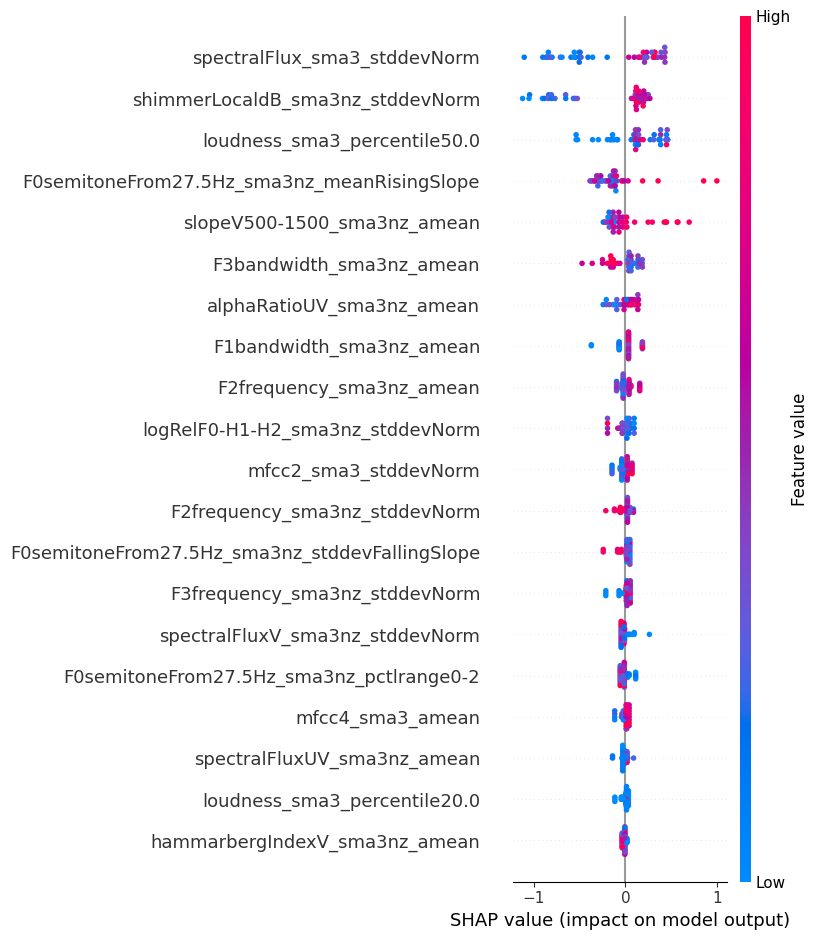

In [65]:
# smile feature만 SHAP 계산

shap.summary_plot(
    shap_values.values[:, [feature_cols.index(f) for f in smile_columns]],
    features=X_test[smile_columns],
    feature_names=smile_columns
)

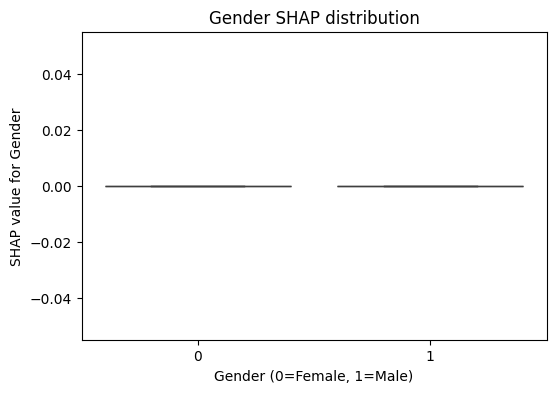

In [60]:
import seaborn as sns

# Gender의 SHAP 값만 추출
gender_idx = feature_cols.index("Gender")
gender_shap = shap_values.values[:, gender_idx]

gender_value = df.loc[X_test.index, "Gender"]

plt.figure(figsize=(6,4))
sns.boxplot(x=gender_value, y=gender_shap)
plt.xlabel("Gender (0=Female, 1=Male)")
plt.ylabel("SHAP value for Gender")
plt.title("Gender SHAP distribution")
plt.show()

In [67]:
from sklearn.metrics import classification_report

# 여성 Performance
female_idx = X_test["Gender"] == 0
print("여성 성능:")
print(classification_report(y_test[female_idx], model.predict(X_test[female_idx])))

# 남성 Performance
male_idx = X_test["Gender"] == 1
print("남성 성능:")
print(classification_report(y_test[male_idx], model.predict(X_test[male_idx])))

여성 성능:
              precision    recall  f1-score   support

           0       0.75      0.88      0.81        17
           1       0.50      0.29      0.36         7

    accuracy                           0.71        24
   macro avg       0.62      0.58      0.59        24
weighted avg       0.68      0.71      0.68        24

남성 성능:
              precision    recall  f1-score   support

           0       0.71      0.94      0.81        16
           1       0.50      0.14      0.22         7

    accuracy                           0.70        23
   macro avg       0.61      0.54      0.52        23
weighted avg       0.65      0.70      0.63        23

